# **Seeing the forest for the trees**
## [Fiddler, Aug. 11, 2023](https://thefiddler.substack.com/p/can-you-see-the-forest-for-the-trees)

> You find yourself amidst what appears to be an infinite grid of trees. For the purposes of this puzzle, let’s suppose each tree is a perfect cylinder. You are at the point (0, 0), but there’s a tree with a radius of 0.25 units (and diameter 0.5 units) centered at every other point in the plane with integer coordinates. Of course, you can’t actually see infinitely many trees. Most of them are obscured by the trees immediately around you. As you look around in all directions, how many distinct trees are you able to see?
>
> EXTRA CREDIT: Once again, you are located at (0, 0) amidst an infinite grid of cylindrical trees. But this time, the trees are narrower, each with a radius of 0.1 units (and diameter 0.2 units). When you look due east, your line of sight is 0.9 units, thanks to the tree centered at (1, 0). But if you look in other directions, it’s possible to see farther away. How long is your longest line of sight? Assume you are looking level with the ground, so that this is a two-dimensional puzzle (rather than three-dimensional one).

### solution by [Laurent Lessard](https://laurentlessard.com)

---

## Helper functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from math import gcd, asin, atan2, sqrt, degrees, log10

# list relatively prime pairs (i,j) with 0 < i < j < n+1, sorted by increasing distance to origin
def rel_prime_points(n):
    p = [(i,j) for j in range(n) for i in range(n) if gcd(i,j)==1]
    return sorted(p, key = lambda v: v[0]**2+v[1]**2)

# represents an angular interval
class Interval:
    def __init__(self, start, end):
        if start >= end:
            raise ValueError("Invalid interval.")
        self.start = start
        self.end = end
        
    def __repr__(self):
        return f"[{self.start}, {self.end}]"
    
    def clip(self):
        self.start = max(0,self.start)
        self.end = min(90,self.end)
        if self.start >= self.end:
            raise ValueError("Bad interval, can't clip it.")
    
    def overlaps(self, other):
        return not (self.end < other.start or other.end < self.start)
    
    def merge(self, other):
        if not self.overlaps(other):
            raise ValueError("Cannot merge non-overlapping intervals.")
        merged_start = min(self.start, other.start)
        merged_end = max(self.end, other.end)
        return Interval(merged_start, merged_end)

# represent angular subset of (0,90)
class RealLineSubset:
    def __init__(self):
        self.intervals = []

    def add_interval(self, interval):
        # Adding the interval and sorting
        self.intervals.append(interval)
        self.intervals.sort(key=lambda x: x.start)

        # Merging overlapping intervals
        i = 0
        while i < len(self.intervals) - 1:
            if self.intervals[i].overlaps(self.intervals[i + 1]):
                merged_interval = self.intervals[i].merge(self.intervals[i + 1])
                self.intervals[i] = merged_interval
                
                # Remove the next interval which has been merged
                del self.intervals[i + 1]
            else:
                i += 1
                
    def measure(self):
        return sum( interval.end - interval.start for interval in self.intervals)        

    def __repr__(self):
        return " U ".join(map(str, self.intervals))
    
# retrieve angular range of a given pair
def angular_range(point, r):
    x,y = point
    d = sqrt(x**2 + y**2)
    mid = degrees(atan2(y,x))
    spread = degrees(asin(r/d))
    return Interval(mid-spread, mid+spread)

# retrieve the list of critical points
def get_critical_points( N, r ):
    pointlist = rel_prime_points(N)
    s = RealLineSubset()
    criticalpoints = []
    m = s.measure()

    for p in pointlist:
        s.add_interval(angular_range(p,r))
        mnew = s.measure()
        if mnew > m:  # i.e., this point made a contribution
            criticalpoints.append(p)
            m = mnew
        if mnew == 90:
            break
    return criticalpoints

# count all the visible points
def count_visible_points( N, r ):
    return 4*len( get_critical_points(N,r) ) - 4
    
# find farthest visible point
def measure_line_of_sight( N, r ):
    p = get_critical_points(N,r)[-1]
    return sqrt(p[0]**2 + p[1]**2) - r

# make a plot of the points and their rays
def plot_points( points, r ):
    fig, ax = plt.subplots(figsize=(6,6))

    for (x,y) in points:
        circle = patches.Circle((x,y),radius=r,fc='blue',zorder=5)
        ax.add_patch(circle)
        ax.plot( (0,x), (0,y), 'b-' )
        
    xmax = max(p[0] for p in points)
    ymax = max(p[1] for p in points)
    
    ax.set_xlim(0,xmax+0.5)
    ax.set_ylim(0,ymax+0.5)
    ax.set_xticks(range(0, xmax+1))
    ax.set_yticks(range(0, ymax+1))
    ax.grid()

## Solve main problem (counting visible trees)
Radius is 0.25, and we ask how many trees are visible

There are 32 visible trees.


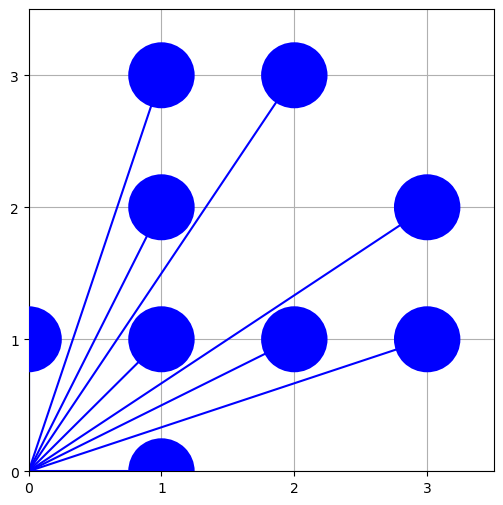

In [2]:
N = 20
r = 0.25
criticalpoints = get_critical_points( N, r )
plot_points( criticalpoints, r )
print( f"There are {count_visible_points( N, r )} visible trees." )

## Solve bonus problem (measuring max line-of-sight)

Radius is 0.1 and we ask what is the farthest visible point.

_Note:_ I wasn't sure how to interpret "line-of-sight" so I found the farthest visible tree and subtracted its radius. In reality, other parts of that same tree would be slightly farther away. If this is what was intended, then it wouldn't be difficult to calculate it, but it's tedious so I decided to stick with the simpler solution.

The farthest line of sight is 9.748857801796104.


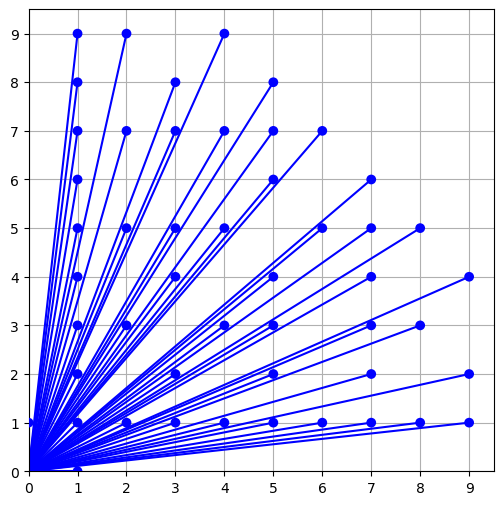

In [3]:
N = 20
r = 0.1
criticalpoints = get_critical_points( N, r )
plot_points( criticalpoints, r )
print( f"The farthest line of sight is {measure_line_of_sight( N, r )}." )

## EXTRA: how do these things change as a function of radius?

First plotted on a log-log scale, and then on a regular scale.

In [4]:
rmin = 0.03
N = 50

rvalues = np.logspace( log10(rmin), 0, 1000 )
vis = []
los = []
for r in rvalues:
    pts = get_critical_points(N,r)
    vis.append( 4*len(pts) - 4 )
    los.append( sqrt(pts[-1][0]**2 + pts[-1][1]**2) - r )

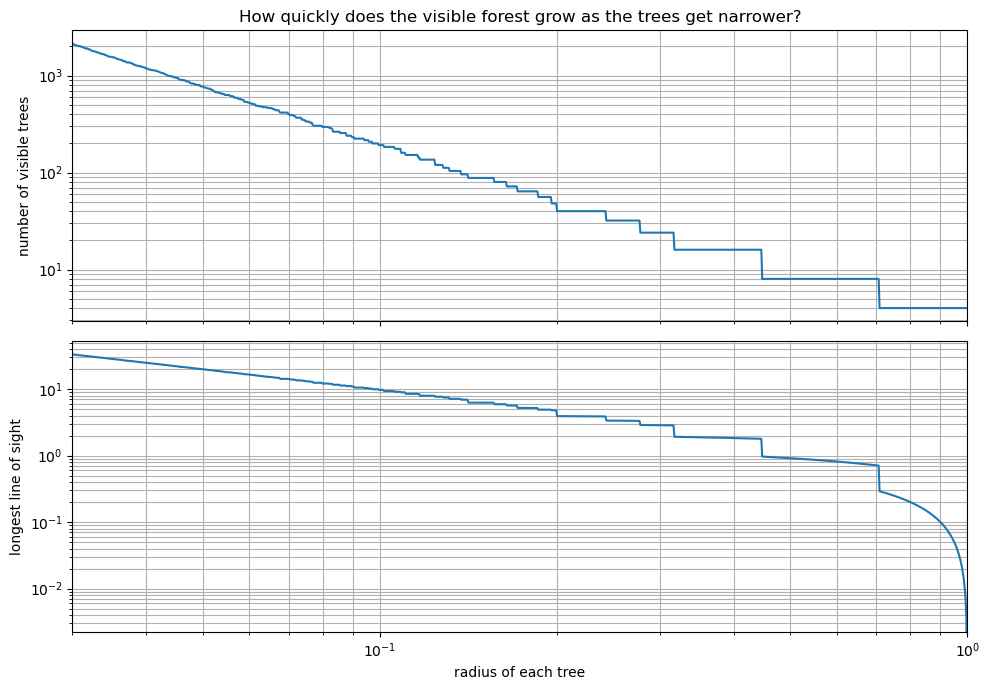

In [5]:
fig, (pv, pl) = plt.subplots(2,1,figsize=(10,7), sharex=True)

pv.loglog(rvalues,vis,'-')
pv.grid(which='both')
pv.set_xlim(rmin,1)
pv.set_ylabel("number of visible trees")
pv.set_title("How quickly does the visible forest grow as the trees get narrower?")

pl.loglog(rvalues,los,'-')
pl.set_xlim(rmin,1)
pl.grid(which='both')
pl.set_ylabel("longest line of sight")
pl.set_xlabel("radius of each tree")

fig.tight_layout()

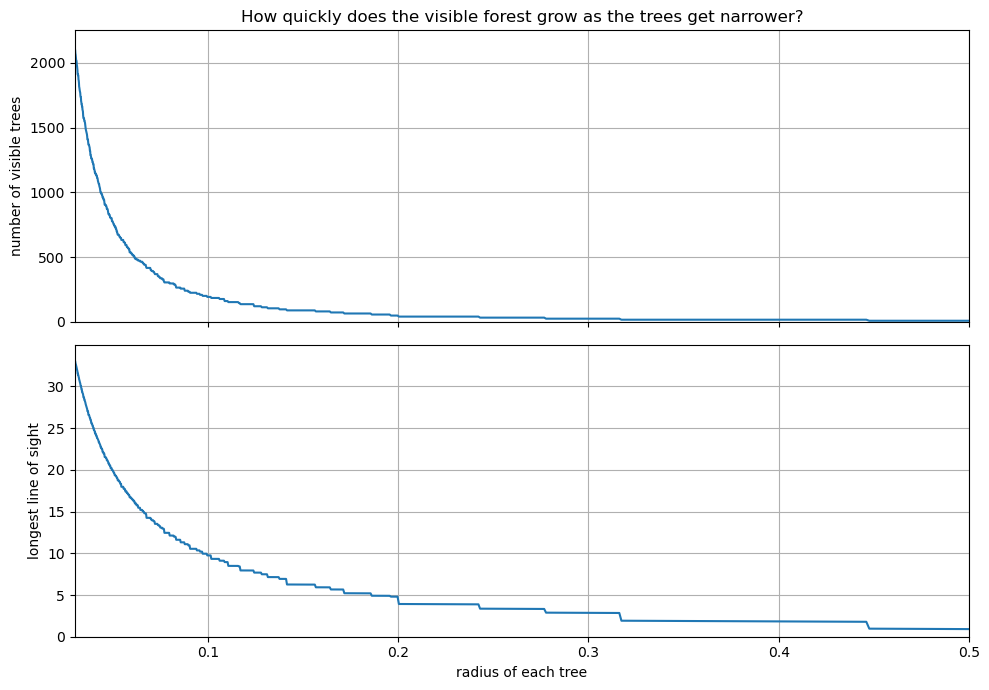

In [6]:
fig, (pv, pl) = plt.subplots(2,1,figsize=(10,7), sharex=True)

pv.plot(rvalues,vis,'-')
pv.grid(which='both')
pv.set_xlim(rmin,0.5)
pv.set_ylim(bottom=0)
pv.set_ylabel("number of visible trees")
pv.set_title("How quickly does the visible forest grow as the trees get narrower?")

pl.plot(rvalues,los,'-')
pl.set_xlim(rmin,0.5)
pl.set_ylim(bottom=0)
pl.grid(which='both')
pl.set_ylabel("longest line of sight")
pl.set_xlabel("radius of each tree")

fig.tight_layout()